In [1]:
import numpy as np 
import pandas as pd 

['train.csv', 'test.csv']


In [2]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

In [3]:
print(train_df.shape)
print(test_df.shape)

(31962, 3)
(17197, 2)


In [4]:
train_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
test_df.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [6]:
train_df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

As shown above large number of tweets are not racist/sexist.

In [7]:
pos_tweet = train_df['label'].value_counts()[0]
neg_tweet = train_df['label'].value_counts()[1]

total = len(train_df)

print("percentage of positive tweets : ", (pos_tweet/total)*100 )
print("percentage of negative tweets : ", (neg_tweet/total)*100)

percentage of positive tweets :  92.98542018647143
percentage of negative tweets :  7.014579813528565


In [8]:
train_df[train_df['label'] == 1].head()

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...


**Preprocessing steps :**
1. As twitter handles(@user) are not giving any useful information therefore we remove it.
2. Remove html tags.
3. Decontract text like won't => would not 
4. Removing punctuations, non-alphabetic character.
5. remove small words like any, all, his, her as this words are not giving any useful information.
6. lowercase the all the words.
7. remove stop words.
8. do stemming 

In [9]:
train_df['tweet'][0]

' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

In [10]:
class Decontract():
    
    pattern = [(r'won\'t', ' will not'),
                 (r'\'s', ' is'),
                 (r'don\'t', ' do not'),
                 (r'can\'t', ' can not'),
                 (r'n\'t','not'),
                 (r'\'re','are'),
                 (r'\'d','would'),
                 (r'\'ll','will'),
                 (r'\'t','not'),
                 (r'\'ve','have'),
                 (r'\'m','am')
                ]
    
    def __init__(self) :
        pass
        
    def replace(self,text):
        for (raw,replace) in self.pattern:
            regex = re.compile(raw)
            text = regex.sub(replace,text)
        return text

In [11]:
import re
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
decontract = Decontract() 
stopWords = set(stopwords.words('english'))

def preprocessing(sentence) :
    
    #removing tweeter handles
    sentence = re.sub(r'@[\w]*','', sentence)
    
    #removing html tags
    sentence = BeautifulSoup(sentence, 'html.parser').get_text()
    
    #Decontract words
    sentence = decontract.replace(sentence)
    
    #remove non-alphabetic characters
    sentence = re.sub('[^A-Za-z]+'," ", sentence)
    
    #remove all words with length less than 3 and lower case the words
    sentence = ' '.join([word.lower() for word in sentence.split() if len(word)>3])

    #removing stop words
    sentence = ' '.join([word for word in sentence.split() if word not in stopWords])
    
    #stemming the word using porterStemmer
    sentence = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(sentence)])
    
    return sentence
    
    
    

In [12]:
train_df['preprocessed_tweet'] = train_df['tweet'].apply(preprocessing)

In [13]:
train_df.head()

,id,label,tweet,preprocessed_tweet
0,1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunction
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit cause offer wheelchair van ...
2,3,0,bihday your majesty,bihday majesty
3,4,0,#model i love u take with u all the time in ...,model love take time
4,5,0,factsguide: society now #motivation,factsguide society motivation


In [14]:
train_df.drop(['id','tweet'],axis = 1, inplace = True)
train_df.head()

,label,preprocessed_tweet
0,0,father dysfunctional selfish drag kid dysfunction
1,0,thanks lyft credit cause offer wheelchair van ...
2,0,bihday majesty
3,0,model love take time
4,0,factsguide society motivation


In [15]:
y = train_df['label']
train_df.drop(['label'],axis = 1, inplace = True)
train_df.head()

,preprocessed_tweet
0,father dysfunctional selfish drag kid dysfunction
1,thanks lyft credit cause offer wheelchair van ...
2,bihday majesty
3,model love take time
4,factsguide society motivation


**Splitting data into train,cv and test**

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

**Vectorizing text data**

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['preprocessed_tweet'].values)

X_train_tfidf = vectorizer.transform(X_train['preprocessed_tweet'].values)
X_cv_tfidf = vectorizer.transform(X_cv['preprocessed_tweet'].values)
X_test_tfidf = vectorizer.transform(X_test['preprocessed_tweet'].values)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
feature_names = vectorizer.get_feature_names()

After vectorizations
(14347, 1453) (14347,)
(7067, 1453) (7067,)
(10548, 1453) (10548,)


In [18]:
#sentiments strength of tweet of X_train
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from tqdm import tqdm

sid = SentimentIntensityAnalyzer() 

neg_sentiment = []
neu_sentiment = []
pos_sentiment = []
com_sentiment = []

for sentence in tqdm(X_train['preprocessed_tweet']):
    vector = sid.polarity_scores(sentence)
    neg_sentiment.append(vector['neg'])
    neu_sentiment.append(vector['neu'])
    pos_sentiment.append(vector['pos'])
    com_sentiment.append(vector['compound'])
    
X_train_neg_sentiment = np.array(neg_sentiment).reshape(-1,1)
X_train_neu_sentiment = np.array(neu_sentiment).reshape(-1,1)
X_train_pos_sentiment = np.array(pos_sentiment).reshape(-1,1)
X_train_com_sentiment = np.array(com_sentiment).reshape(-1,1)

/opt/conda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
100%|██████████| 14347/14347 [00:02<00:00, 5490.76it/s]


In [19]:
#sentiments strength of tweet of X_cv

sid = SentimentIntensityAnalyzer() 

neg_sentiment = []
neu_sentiment = []
pos_sentiment = []
com_sentiment = []

for sentence in tqdm(X_cv['preprocessed_tweet']):
    vector = sid.polarity_scores(sentence)
    neg_sentiment.append(vector['neg'])
    neu_sentiment.append(vector['neu'])
    pos_sentiment.append(vector['pos'])
    com_sentiment.append(vector['compound'])
    
X_cv_neg_sentiment = np.array(neg_sentiment).reshape(-1,1)
X_cv_neu_sentiment = np.array(neu_sentiment).reshape(-1,1)
X_cv_pos_sentiment = np.array(pos_sentiment).reshape(-1,1)
X_cv_com_sentiment = np.array(com_sentiment).reshape(-1,1)

100%|██████████| 7067/7067 [00:01<00:00, 5513.76it/s]


In [20]:
#sentiments strength of tweet of X_test

sid = SentimentIntensityAnalyzer() 

neg_sentiment = []
neu_sentiment = []
pos_sentiment = []
com_sentiment = []

for sentence in tqdm(X_test['preprocessed_tweet']):
    vector = sid.polarity_scores(sentence)
    neg_sentiment.append(vector['neg'])
    neu_sentiment.append(vector['neu'])
    pos_sentiment.append(vector['pos'])
    com_sentiment.append(vector['compound'])
    
X_test_neg_sentiment = np.array(neg_sentiment).reshape(-1,1)
X_test_neu_sentiment = np.array(neu_sentiment).reshape(-1,1)
X_test_pos_sentiment = np.array(pos_sentiment).reshape(-1,1)
X_test_com_sentiment = np.array(com_sentiment).reshape(-1,1)

100%|██████████| 10548/10548 [00:01<00:00, 5534.89it/s]


In [21]:
from scipy.sparse import hstack

X_train = hstack((X_train_neg_sentiment,X_train_neu_sentiment,X_train_pos_sentiment,X_train_com_sentiment,X_train_tfidf )).tocsr()
X_cv = hstack((X_cv_neg_sentiment,X_cv_neu_sentiment,X_cv_pos_sentiment,X_cv_com_sentiment,X_cv_tfidf )).tocsr()
X_test = hstack((X_test_neg_sentiment,X_test_neu_sentiment,X_test_pos_sentiment,X_test_com_sentiment,X_test_tfidf )).tocsr()

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(14347, 1457) (14347,)
(7067, 1457) (7067,)
(10548, 1457) (10548,)


**Modelling**

1) Applying Logistic Regression

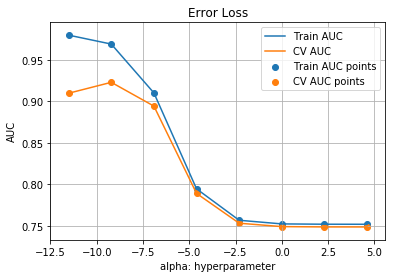

In [22]:
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc = []
alpha = [0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

for a in alpha:
    clf = SGDClassifier(loss = 'log', penalty = 'l2' , alpha = a,class_weight = "balanced")
    clf.fit(X_train,y_train)
    y_train_pred = clf.predict_proba(X_train)[:,1]
    y_cv_pred = clf.predict_proba(X_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
plt.plot(np.log(alpha), train_auc, label = "Train AUC")
plt.plot(np.log(alpha), cv_auc, label = "CV AUC")

plt.scatter(np.log(alpha), train_auc, label = "Train AUC points")
plt.scatter(np.log(alpha), cv_auc, label = "CV AUC points")

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Error Loss")
plt.grid()
plt.show()

In [23]:
lr_tfidf_best_alpha = 0.1

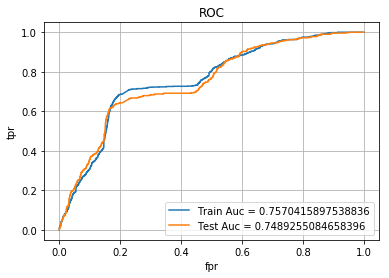

In [24]:
from sklearn.metrics import roc_curve,auc

lr = SGDClassifier(loss = 'log', alpha = lr_tfidf_best_alpha, penalty = 'l2',class_weight = "balanced")
lr.fit(X_train, y_train)

y_train_pred = lr.predict_proba(X_train)[:,1]
y_test_pred = lr.predict_proba(X_test)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, y_cv_pred)

train_auc_tfidf_lr = auc(train_fpr,train_tpr)
test_auc_tfidf_lr = auc(test_fpr, test_tpr)

plt.plot(train_fpr,train_tpr,label = "Train Auc = "+str(train_auc_tfidf_lr))
plt.plot(test_fpr,test_tpr,label = "Test Auc = "+str(test_auc_tfidf_lr))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC")
plt.grid()
plt.show()

Train Confusion matrix


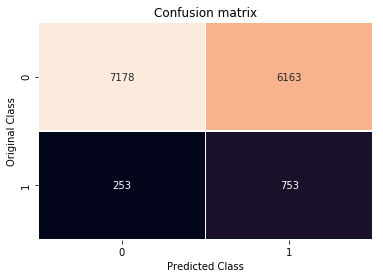

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
print("Train Confusion matrix")
train_cm = confusion_matrix(y_train,lr.predict(X_train))
ax = sns.heatmap(train_cm, annot=True, fmt="d", linewidths=.5, cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title("Confusion matrix")
ax

Test Confusion matrix


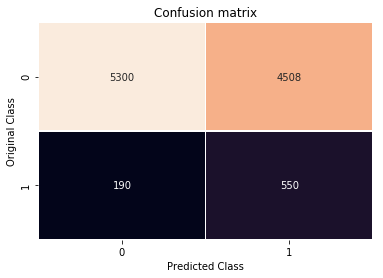

In [26]:
print("Test Confusion matrix")
train_cm = confusion_matrix(y_test,lr.predict(X_test))
ax = sns.heatmap(train_cm, annot=True, fmt="d", linewidths=.5, cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title("Confusion matrix")
ax

2) linear SVM

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

train_auc = []
cv_auc = []

alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1','l2']

parameters = {'alpha' : alpha, 'penalty' : penalty}

svm = SGDClassifier(loss = 'hinge', class_weight = 'balanced')
clf = GridSearchCV(svm, parameters, scoring = 'roc_auc', cv=8)
clf.fit(X_train, y_train) 

print(clf.best_estimator_.alpha)
print(clf.best_estimator_.penalty)

0.001
l2


In [28]:
print(clf.score(X_test,y_test))

0.8967619510824036


In [29]:
lr_svm_tfidf_best_alpha = 0.01
lr_svm_tfidf_best_penalty = 'l2'

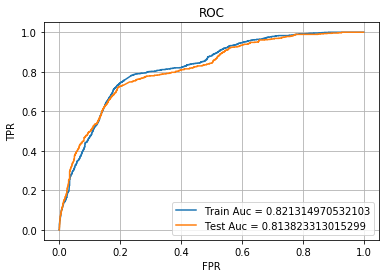

In [30]:
from sklearn.calibration import CalibratedClassifierCV

lr_svm = SGDClassifier(loss = 'hinge', class_weight = 'balanced', alpha = lr_svm_tfidf_best_alpha, penalty = lr_svm_tfidf_best_penalty )

#configuring calibrated model to obtain output probabilities, because SGDClassifier with hinge los s don't give output probabilities 
lr_svm_cc = CalibratedClassifierCV(lr_svm, cv = 8)
lr_svm_cc.fit(X_train,y_train)

y_train_pred = lr_svm_cc.predict_proba(X_train)[:,1]
y_test_pred = lr_svm_cc.predict_proba(X_test)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train,y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

train_auc_tfidf_lr_svm = auc(train_fpr, train_tpr)
test_auc_tfidf_lr_svm = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label = "Train Auc = "+str(train_auc_tfidf_lr_svm))
plt.plot(test_fpr, test_tpr, label = "Test Auc = "+str(test_auc_tfidf_lr_svm))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.grid()
plt.show()

3) Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

train_auc = []
cv_auc = []

max_depth = [1, 5, 10, 50, 100, 500, 1000]
n_estimators  = [5, 10, 100, 500, 1000]

for estimator in n_estimators:
    train_lst = []
    cv_lst = []
    for depth in max_depth:
        clf = RandomForestClassifier(class_weight = "balanced_subsample", max_depth = depth, n_estimators = estimator, n_jobs = -1)
        clf.fit(X_train, y_train)
        
        y_train_pred = clf.predict_proba(X_train)[:,1]
        y_cv_pred = clf.predict_proba(X_cv)[:,1]
        
        train_lst.append(roc_auc_score(y_train,y_train_pred))
        cv_lst.append(roc_auc_score(y_cv,y_cv_pred))
        
    train_auc.append(train_lst)
    cv_auc.append(cv_lst)

In [32]:
# creating dataframe of train auc for heatmap
df = pd.DataFrame(train_auc)

Text(33.0, 0.5, 'n_estimators')

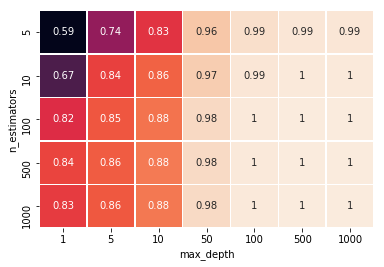

In [33]:
#heat map of train auc
ax = sns.heatmap(df, annot=True, linewidths=.5, cbar=False,yticklabels=n_estimators, xticklabels=max_depth)
ax
plt.xlabel("max_depth");
plt.ylabel("n_estimators")

In [34]:
#creating data frame of cv_auc for heat map
df = pd.DataFrame(cv_auc)

Text(33.0, 0.5, 'n_estimators')

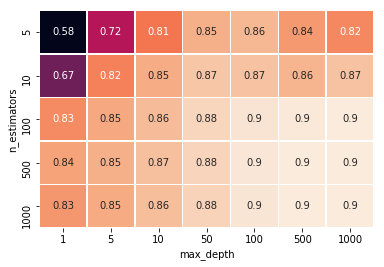

In [35]:
#heat map of cv auc
ax = sns.heatmap(df, annot = True, linewidths=.5, cbar=False,yticklabels=n_estimators, xticklabels=max_depth)
ax
plt.xlabel("max_depth");
plt.ylabel("n_estimators")

In [36]:
rf_best_max_depth = 10
rf_best_n_estimators = 500

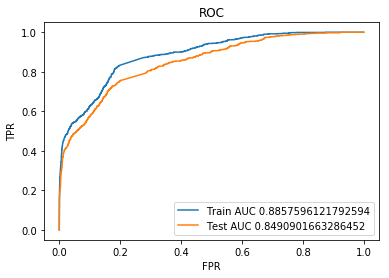

In [37]:
rf = RandomForestClassifier(class_weight = "balanced_subsample", max_depth = rf_best_max_depth, n_estimators = rf_best_n_estimators, n_jobs = -1)
rf.fit(X_train,y_train)
y_train_pred = rf.predict_proba(X_train)[:,1]
y_test_pred = rf.predict_proba(X_test)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

train_auc_tfidf_rf = auc(train_fpr, train_tpr)
test_auc_tfidf_rf = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label = "Train AUC " + str(train_auc_tfidf_rf))
plt.plot(test_fpr, test_tpr, label = "Test AUC " +str(test_auc_tfidf_rf))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

4) XGBOOST

In [38]:
from xgboost.sklearn import XGBClassifier

train_auc = []
cv_auc = []

max_depth = [3,5,7,9]
n_estimators = [5,10,100,500,1000]

for estimator in n_estimators :
    train_lst = []
    cv_lst = []
    for depth in max_depth : 
        xgb_model = XGBClassifier(max_depth = depth, n_estimators = estimator, n_jobs = -1)
        xgb_model.fit(X_train, y_train)
        
        y_train_pred = xgb_model.predict_proba(X_train)[:,1]
        y_cv_pred = xgb_model.predict_proba(X_cv)[:,1]
        
        train_lst.append(roc_auc_score(y_train, y_train_pred))
        cv_lst.append(roc_auc_score(y_cv, y_cv_pred))
        
    train_auc.append(train_lst)
    cv_auc.append(cv_lst)
    


Text(33.0, 0.5, 'n_estimators')

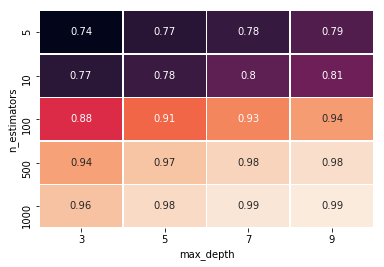

In [39]:
df = pd.DataFrame(train_auc)

ax = sns.heatmap(df, annot=True, linewidths=.5, cbar=False,yticklabels=n_estimators, xticklabels=max_depth)
ax
plt.xlabel("max_depth")
plt.ylabel("n_estimators")

Text(33.0, 0.5, 'n_estimators')

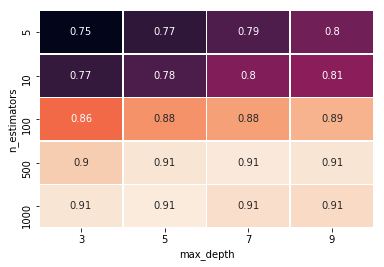

In [40]:
df = pd.DataFrame(cv_auc)
ax = sns.heatmap(df, annot=True, linewidths=.5, cbar=False,yticklabels=n_estimators, xticklabels=max_depth)
ax
plt.xlabel("max_depth")
plt.ylabel("n_estimators")

In [41]:
rf_best_max_depth = 3
rf_best_n_estimators = 500

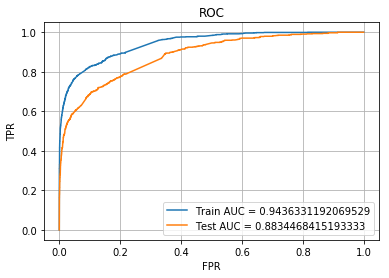

In [42]:
xgb_model = XGBClassifier(max_depth = rf_best_max_depth, n_estimators = rf_best_n_estimators, n_jobs = -1)
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict_proba(X_train)[:,1]
y_test_pred = xgb_model.predict_proba(X_test)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train,y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

train_auc_tfidf_xgb = auc(train_fpr, train_tpr)
test_auc_tfidf_xgb = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label = "Train AUC = " + str(train_auc_tfidf_xgb))
plt.plot(test_fpr, test_tpr, label = "Test AUC = " + str(test_auc_tfidf_xgb))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.grid()
plt.show()

<h3>Summary of each model with their respective AUC Score</h3>

In [43]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model", "AUC"]
x.add_row(["Logistic Regression",test_auc_tfidf_lr])
x.add_row(["Linear SVM",test_auc_tfidf_lr_svm])
x.add_row(["Random Forest",test_auc_tfidf_rf])
x.add_row(["XGBoost",test_auc_tfidf_xgb])
print(x)

+---------------------+--------------------+
|        Model        |        AUC         |
+---------------------+--------------------+
| Logistic Regression | 0.7489255084658396 |
|      Linear SVM     | 0.813823313015299  |
|    Random Forest    | 0.8490901663286452 |
|       XGBoost       | 0.8834468415193333 |
+---------------------+--------------------+


**Observation :** From above table it seems that XGBoost performs better than other models therefore we use XGBoost with other vectorizer or for prediction of test dataset.

<h3>Prediction on Test dataset using XGBoost</h3>

In [44]:
test_df['preprocessed_tweet'] = test_df['tweet'].apply(preprocessing)

In [45]:
test_df.head()

,id,tweet,preprocessed_tweet
0,31963,#studiolife #aislife #requires #passion #dedic...,studiolife aislife requires passion dedication...
1,31964,@user #white #supremacists want everyone to s...,white supremacist want everyone bird movie
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe way heal acne altwaystoheal healthy healing
3,31966,is the hp and the cursed child book up for res...,cursed child book reservation already harrypot...
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",bihday amazing hilarious nephew ahmir uncle da...


In [46]:
test_df.drop(['id','tweet'],axis = 1, inplace = True)
test_df.head()

,preprocessed_tweet
0,studiolife aislife requires passion dedication...
1,white supremacist want everyone bird movie
2,safe way heal acne altwaystoheal healthy healing
3,cursed child book reservation already harrypot...
4,bihday amazing hilarious nephew ahmir uncle da...


In [47]:
#applying tfidf vectorizer on preprocessed_tweet
test_df_tfidf = vectorizer.transform(test_df['preprocessed_tweet'].values)

In [48]:
#sentiments strength of tweet of test dataframe
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from tqdm import tqdm

sid = SentimentIntensityAnalyzer() 

neg_sentiment = []
neu_sentiment = []
pos_sentiment = []
com_sentiment = []

for sentence in tqdm(test_df['preprocessed_tweet']):
    vector = sid.polarity_scores(sentence)
    neg_sentiment.append(vector['neg'])
    neu_sentiment.append(vector['neu'])
    pos_sentiment.append(vector['pos'])
    com_sentiment.append(vector['compound'])
    
test_df_neg_sentiment = np.array(neg_sentiment).reshape(-1,1)
test_df_neu_sentiment = np.array(neu_sentiment).reshape(-1,1)
test_df_pos_sentiment = np.array(pos_sentiment).reshape(-1,1)
test_df_com_sentiment = np.array(com_sentiment).reshape(-1,1)

100%|██████████| 17197/17197 [00:03<00:00, 5487.01it/s]


In [49]:
#creating data matrix 
test_data_matrix = hstack((test_df_neg_sentiment,test_df_neu_sentiment,test_df_pos_sentiment,test_df_com_sentiment,test_df_tfidf )).tocsr()

In [50]:
#Predicting using XGBoost model
y_pred = xgb_model.predict(test_data_matrix)

In [51]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])